# Visual stimulation monitor synchronisation

Bonsai controls visual display and saves a log everytime it asks for a frame to be rendered. However there is an unknown delay (~2 frames) between this render frame event and the actual display time. Furthermore some frames are skipped.

To figure out which frame is displayed when we put a photodiode in front of the monitor and display a pseudo-random sequence of alternating grey value. 

This notebook show how we use the frame logger and the photodiode signal to determine exact frame identity at each point of time. It has 3 main steps

**1. Detect frames on photodiode signal**

**2. Cross-correlate frame with sequence to find expected lag**

**3. Match cross correlation results to frame logger**


### Load example data

This next section just loads one example recording to be used for the rest of the notebook.

Define the session we want:

In [34]:
PROJECT = 'hey2_3d-vision_foodres_20220101'
MOUSE = 'Test'
SESSION = 'S20221013'
RECORDING = 'R203221_SpheresPermTubeReward'
MESSAGES = 'Test_S20221013_R203221_SpheresPermTubeReward_harpmessage.bin'

Load it

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import flexiznam as flm

data_root = flm.PARAMETERS['data_root']
msg = Path(data_root['raw']) / PROJECT / MOUSE / SESSION / RECORDING / MESSAGES
p_msg = Path(data_root['processed']) / PROJECT / MOUSE / SESSION / RECORDING
p_msg = p_msg / (msg.stem + '.npz')
if p_msg.is_file():
    harp_messages = np.load(p_msg)
else:
    harp_messages = harp.load_harp(msg)
    p_msg.parent.mkdir(parents=True, exist_ok=True)
    np.savez(p_msg, **harp_messages)

frame_log = pd.read_csv(msg.parent / 'FrameLog.csv')
expected_sequence = pd.read_csv(msg.parent / 'random_sequence.csv',
                                header=None).loc[:, 0].values
step_values = frame_log.PhotoQuadColor.unique()
ao_time = harp_messages['analog_time']
photodiode = harp_messages['photodiode']
ao_sampling = 1 / np.mean(np.diff(ao_time))

print('Data loaded.')
print('Recording is %d s long.' % (frame_log.HarpTime.values[-1]-frame_log.HarpTime.values[0]))

Data loaded.
Recording is 174 s long.


# Normal usage

This is using the main master function:

In [36]:
from cottage_analysis.preprocessing import find_frames
frame_rate = 144
frames_df, db_dict = find_frames.sync_by_correlation(frame_log, ao_time, photodiode,
                                            time_column='HarpTime', 
                                            sequence_column='PhotoQuadColor',
                                            num_frame_to_corr=6,
                                            maxlag=3./frame_rate, 
                                            expected_lag=2./frame_rate,
                                            frame_rate=frame_rate, 
                                            correlation_threshold=0.8,
                                                     relative_corr_thres=0.02,
                                            minimum_lag=1./frame_rate, 
                                            do_plot=False, verbose=True, debug=True)

Found 22468 frames out of 24301 Render (92%, 1833 dropped)
Starting crosscorrelation


/nemo/lab/znamenskiyp/home/users/blota/code/cottage_analysis/cottage_analysis/utilities/continuous_data_analysis.py:52: RuntimeWarning: invalid value encountered in divide
  corr = (circ_y.dot(x) / x.size - (circ_y.mean(axis=1) * x.mean())) / \


Frame 22463 at sample 174855 is too close from end of recording
Frame 22464 at sample 174859 is too close from end of recording
Frame 22465 at sample 174872 is too close from end of recording
Frame 22465 at sample 174872 is too close from end of recording
Frame 22466 at sample 174897 is too close from end of recording
Frame 22466 at sample 174897 is too close from end of recording
Frame 22466 at sample 174897 is too close from end of recording
Frame 22467 at sample 174907 is too close from end of recording
Frame 22467 at sample 174907 is too close from end of recording
Frame 22467 at sample 174907 is too close from end of recording
done (6 s)
Sync'ed 16135 frames easily. That's 71% of the recording.
Matching frame to logger
done (3 s)
722 frames are not synced. Thats 0.03 %


In [37]:
frames_df.head()

,onset_sample,offset_sample,peak_sample,include_skip,onset_time,offset_time,peak_time,lag_bef,peak_corr_bef,closest_frame_bef,...,peak_corr_aft,closest_frame_aft,quadcolor_aft,photodiode,is_jump,closest_frame,lag,sync_reason,crosscorr_picked,quadcolor
0,459,467,465,False,3.845461e+07,3.845461e+07,3.845461e+07,0.025,NaN,0,...,0.859594,1,1.00,1.046296,0,1.0,0.014,relative peak corr,center,1.00
1,467,473,469,False,3.845461e+07,3.845461e+07,3.845461e+07,0.033,NaN,0,...,0.981815,1,1.00,0.902778,1,1.0,0.016,relative peak corr,aft,1.00
2,473,480,477,False,3.845461e+07,3.845461e+07,3.845461e+07,0.014,0.952246,3,...,0.977029,2,0.75,0.685185,0,2.0,0.016,relative peak corr,aft,0.75
3,480,487,483,False,3.845461e+07,3.845461e+07,3.845461e+07,0.015,0.927220,3,...,0.930598,3,1.00,0.805556,0,3.0,0.015,consensus,bef,1.00
4,487,495,491,False,3.845461e+07,3.845461e+07,3.845461e+07,0.016,0.906048,4,...,0.690165,4,0.00,0.055556,0,4.0,0.016,consensus,bef,0.00


In [38]:
frames_df.sync_reason.value_counts()

consensus                                   16098
only fit                                     2137
partial consensus                            1768
relative peak corr                           1114
not synced                                    722
relative peak corr & photodiode matching      264
photodiode matching                           159
fixing time travel (to past)                  115
fixing time travel (to future)                 91
Name: sync_reason, dtype: int64

# Detailled description

How does it work? The alignment is made in 3 steps:

- detect frames
- crosscorrelated with expected sequence
- align results

## Detect frames

The frame detection is simple: filter a bit to smooth local extrema, `diff` to find fast changes and detect peaks on that `diff` trace. This should detect all frame borders. In between these borders, look for the `diff` minimum to find the frame peak (be it a maximum or a minium)

Detection can be done independently using `detect_frame_onset`.


In [39]:
pd_sampling = 1/np.mean(np.diff(ao_time))
out = find_frames.detect_frame_onset(photodiode=photodiode,
                                     frame_rate=frame_rate,
                                     photodiode_sampling=pd_sampling,
                                     highcut=frame_rate * 3,
                                     debug=True)
frame_borders, peak_index, db_dict = out

You can get an example of detection using `plot_frame_detection_report`. This will give you `num_examples * 2` figures. Half of them are selected on random frames, half are centered around a frame drop.

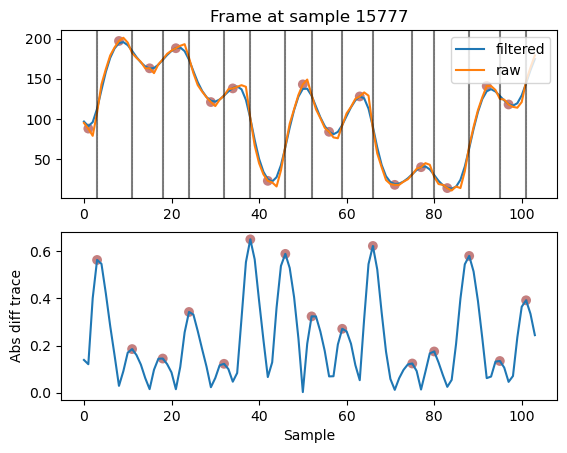

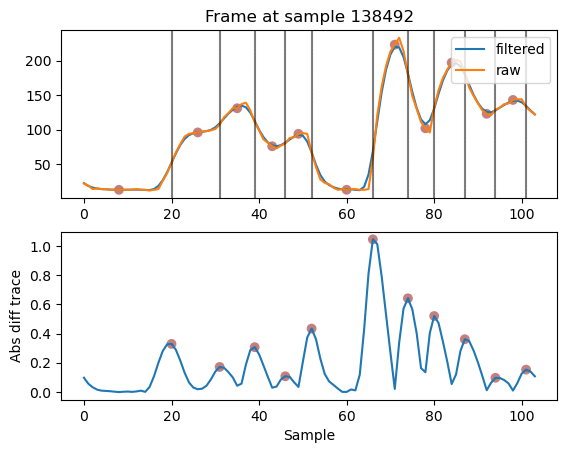

In [40]:
plot_window = np.array([-7.5, 7.5]) / frame_rate * pd_sampling
figs = find_frames.plot_frame_detection_report(border_index=frame_borders,
                                           peak_index=peak_index,
                                           debug_dict=db_dict,
                                           num_examples=1,
                                           plot_window=plot_window,
                                           photodiode=photodiode,
                                           frame_rate=frame_rate,
                                           photodiode_sampling=pd_sampling,
                                           highcut=frame_rate * 3)

## Crosscorrelation

After having detected frames we will try to find where each of them falls in the photodiode sequence. To do that, we start by normalising the photodiode signal between 0 and 1

In [41]:
normed_pd = np.array(photodiode, dtype=float)
normed_pd -= np.quantile(normed_pd, 0.01)
normed_pd /= np.quantile(normed_pd, 0.99)


### Idealised photodiode

Then we generate an idealised version of what the photodiode signal should be (had their been no frame drops).

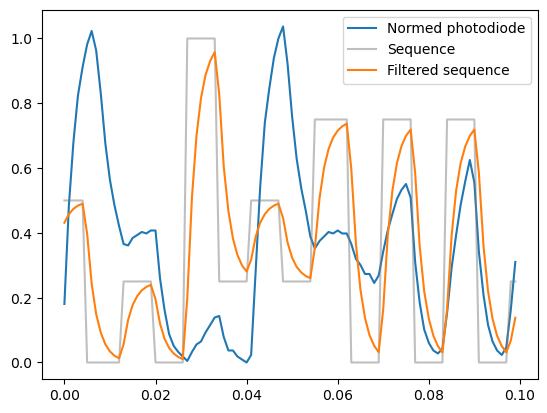

In [42]:
seq_trace, ideal_pd = find_frames.ideal_photodiode(time_base=ao_time,
                                switch_time=frame_log['HarpTime'].values,
                                sequence=frame_log['PhotoQuadColor'].values)

fig = plt.figure()
w = np.array([10000, 10100])
t0 = ao_time[w[0]]
plt.plot(ao_time[slice(*w)] - t0, normed_pd[slice(*w)], label='Normed photodiode')
plt.plot(ao_time[slice(*w)] - t0, seq_trace[slice(*w)], label='Sequence',
         color='grey', alpha=0.5)
plt.plot(ao_time[slice(*w)] - t0, ideal_pd[slice(*w)], label='Filtered sequence')
l = plt.legend()

### Data chunking

Now we want to run the crosscorrelation around each frame.

We need to take a chunk of data that is big enough but short enough. Five or 6 frames seems to get good unique match with the sequence. Use `num_frame_to_corr` to set that.

Then we need to shift the photodiode by a given lag and cut the same chunk of data to correlate. There is no point in testing all the shifts, we now it will be about 2 frames. So we have `expected_lag ~= int(2/frame_rate*ao_sampling)` (in samples). 

To make things reasonably fast we also limit the search to a 3 frames of lag (+/- around expected_lag). With `maxlag ~= int(3/frame_rate*ao_sampling)`

In [43]:
num_frame_to_corr = 6
maxlag_samples = int(np.round(3 / frame_rate * ao_sampling))  # make it into samples
expected_lag_samples = int(np.round(2 /frame_rate * ao_sampling))  # make it into samples

Finally we need to decide if we take the chunk of data before the frame, centered on the frame or after the frame. The best choice depends on if there was a frame drop recently or not. So let's just do the 3.

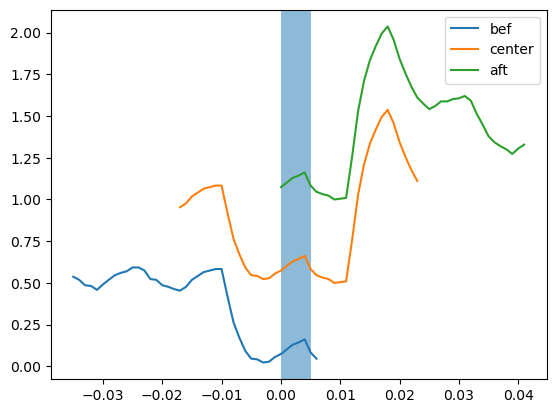

In [44]:
window = [np.array([-1, 1]) * maxlag_samples + 
          np.array(w * num_frame_to_corr / frame_rate
                    * ao_sampling, dtype='int')
              for w in [np.array([-1, 0]), np.array([-0.5, 0.5]), np.array([0, 1])]]
# for bef window, we add 1 frame to have the current frame included
window[0] += int(1/frame_rate * ao_sampling)
# for center window, we shift by 0.5 frame to center
window[1] += int(0.5/frame_rate * ao_sampling)

example_frame = 5234
frame_sample = frame_borders[example_frame]
lab = ['bef', 'center', 'aft']
t0 = ao_time[frame_sample]
for iw, w in enumerate(window):
    part = slice(*w + frame_sample)
    plt.plot(ao_time[part][maxlag_samples:-maxlag_samples+1] - t0, 
             normed_pd[part][maxlag_samples:-maxlag_samples+1] + iw * 0.5, 
             label=lab[iw])
plt.axvspan(ao_time[frame_sample] - t0, ao_time[frame_borders[example_frame + 1]] - t0, 
            alpha=0.5)
_ = plt.legend()

In [45]:
maxlag_samples

21

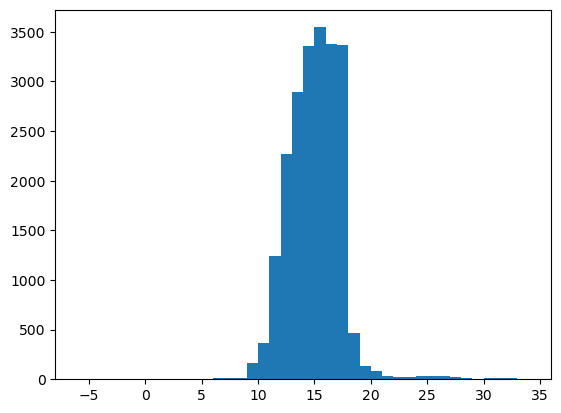

In [46]:
import matplotlib.pyplot as plt
_=plt.hist(frames_df.lag.values*1000, 
           bins=np.arange(frames_df.lag.min()*1000,frames_df.lag.max()*1000))

In [47]:
bad = np.diff(frames_df.closest_frame.values) < 1
frames_df.iloc[1:][bad]

,onset_sample,offset_sample,peak_sample,include_skip,onset_time,offset_time,peak_time,lag_bef,peak_corr_bef,closest_frame_bef,...,peak_corr_aft,closest_frame_aft,quadcolor_aft,photodiode,is_jump,closest_frame,lag,sync_reason,crosscorr_picked,quadcolor
1,467,473,469,False,3.845461e+07,3.845461e+07,3.845461e+07,0.033,NaN,0,...,0.981815,1,1.00,0.902778,1,1.0,0.016,relative peak corr,aft,1.00
542,4624,4630,4627,False,3.845461e+07,3.845461e+07,3.845461e+07,0.011,0.763991,583,...,0.823079,582,0.00,0.310185,0,582.0,0.016,only fit,aft,0.00
747,6284,6289,6285,False,3.845461e+07,3.845461e+07,3.845461e+07,-0.005,0.711417,818,...,0.667892,815,0.75,0.592593,0,815.0,0.013,only fit,center,0.75
882,7394,7402,7397,False,3.845461e+07,3.845461e+07,3.845461e+07,0.011,0.926534,971,...,0.976780,970,0.00,0.009259,0,970.0,0.016,relative peak corr,aft,0.00
1054,8666,8673,8669,False,3.845462e+07,3.845462e+07,3.845462e+07,0.022,0.888797,1147,...,0.651230,1148,0.75,0.805556,0,1147.0,0.022,only fit,bef,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22223,172749,172758,172753,False,3.845478e+07,3.845478e+07,3.845478e+07,0.014,0.895550,23982,...,0.944435,23982,0.00,0.004630,0,23982.0,0.014,consensus,bef,0.00
22383,174099,174105,174101,False,3.845478e+07,3.845478e+07,3.845478e+07,0.013,0.510999,24170,...,0.853749,24169,1.00,0.912037,1,24169.0,0.020,only fit,aft,1.00
22442,174639,174648,174645,False,3.845478e+07,3.845478e+07,3.845478e+07,0.010,0.784715,24246,...,0.889604,24244,0.75,0.458333,0,24244.0,0.025,relative peak corr,aft,0.75
22447,174674,174684,174680,False,3.845478e+07,3.845478e+07,3.845478e+07,0.025,0.889604,24248,...,0.726184,24250,0.25,0.250000,0,24248.0,0.025,only fit,bef,0.25


Add that to the dataframe

## Match cross correlation results to frame logger

Ideally, if there is no frame drop, it does not matter if we look at the frames perceeding or following the frame we want to sync. That should be most of the case.

In [48]:
db = db_dict['debug_info']
normed_pd = np.array(photodiode, dtype=float)
normed_pd -= np.quantile(normed_pd, 0.01)
normed_pd /= np.quantile(normed_pd, 0.99)
db.keys()

KeyError: 'debug_info'

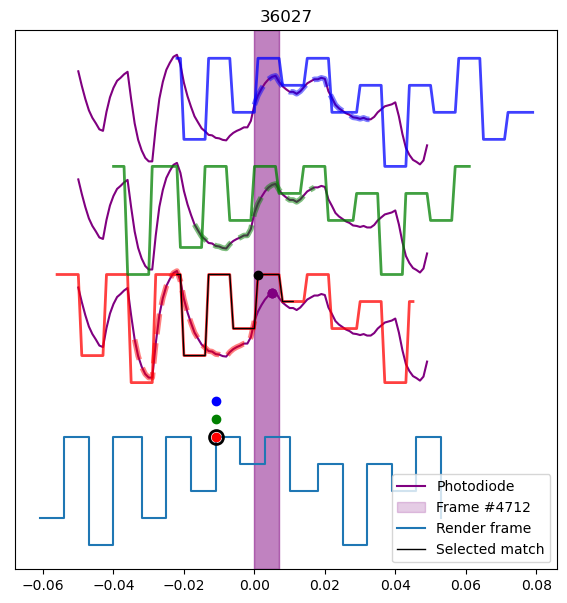

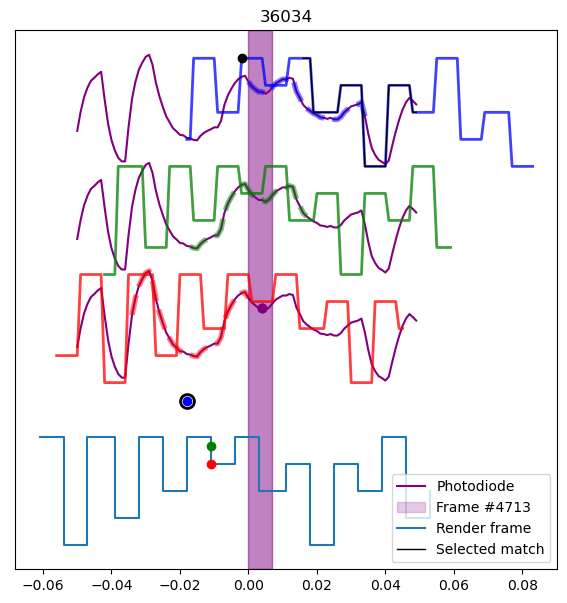

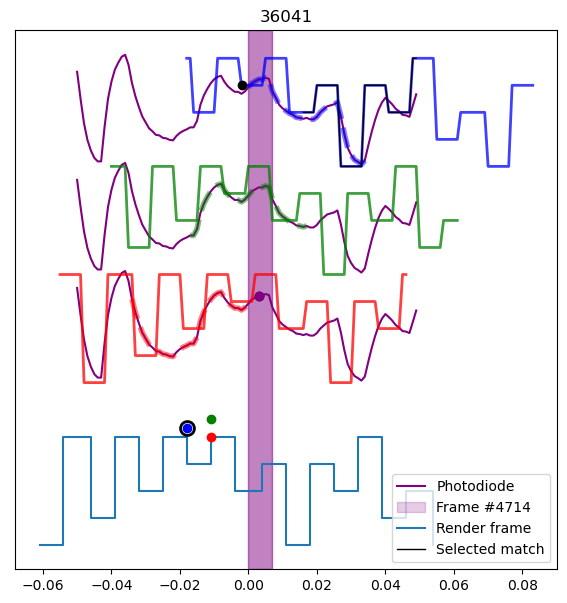

In [ ]:
rng = np.random.default_rng(102)
w = frames_df[frames_df.sync_reason == 'photodiode matching'].index
random_select = [w[i] for i in rng.integers(len(w), size=10)]
bad = np.diff(frames_df.closest_frame.values) < 1
badi = np.where(bad)[0]
random_select = frames_df.iloc[badi[20]+np.array([0, 1, 2], dtype=int)].index
labels = ['bef', 'center', 'aft']
num_frame_to_corr=5
maxlag=int(5./frame_rate*ao_sampling)
expected_lag=int(2./frame_rate*ao_sampling)
window = [np.array([-1, 1]) * maxlag + 
          np.array(w * num_frame_to_corr/frame_rate * ao_sampling, dtype='int')
          for w in [np.array([-1,0]), np.array([-0.5, 0.5]), np.array([0, 1])]]
seq_trace = db['seq_trace']

for frame in random_select:
    #frame = frames_df[~good].index[num]
    #frame = frames_df.index[num]
    fseries = frames_df.loc[frame]
    on_s = fseries.onset_sample
    off_s = fseries.offset_sample
    on_t = fseries.onset_time
    off_t = fseries.offset_time
    w = np.array([-50, 50])
    vfdf = frames_df[(frames_df.onset_sample > w[0] + on_s) &
                     (frames_df.offset_sample < w[1] + off_s)]
    qc = np.array([fseries[['quadcolor_%s' % w for w in labels]]])
    best = fseries.crosscorr_picked
    fig = plt.figure(figsize=(7, 7))
    plt.gca().get_yaxis().set_visible(False)

    col = dict(bef='r', center='g', aft='b')
    for i in range(3):
        label = 'Photodiode' if i == 1 else None
        plt.plot(ao_time[slice(*w+on_s)]-on_t, normed_pd[slice(*w+on_s)] + i,
                 label=label, color='purple')
        label = 'Frame #%d' % frame if i == 1 else None
        plt.axvspan(0, off_t-on_t, color='purple', alpha=0.2, label=label)
        plt.plot(fseries.peak_time - on_t, fseries.photodiode, 'o', color='purple')


    vlog = frame_log[(frame_log.HarpTime > w[0] / ao_sampling + on_t - fseries.lag_bef) &
                     (frame_log.HarpTime < w[1] / ao_sampling + off_t)]
    plt.plot(vlog.HarpTime.values - on_t, vlog.PhotoQuadColor - 1.5, drawstyle='steps-post', 
             label='Render frame')

    i = 0
    for win, lab in zip(window, ['bef', 'center', 'aft']):
        cut_win = win + maxlag * np.array([1,-1], dtype=int)
        l = fseries['lag_%s' % lab]
        part = seq_trace[slice(*win + on_s)]
        cut_part = seq_trace[slice(*cut_win + on_s)]
        x = normed_pd[slice(*win+on_s)][maxlag :-maxlag + 1]
        
        plt.plot(ao_time[slice(*win+on_s)]-on_t + l, part + i, alpha=0.75, lw=2,
                color=col[lab])
        plt.plot(ao_time[slice(*win+on_s)][maxlag :-maxlag + 1] -on_t,
                 x + i, alpha=0.5, lw=4, ls='--', color=col[lab])
        
        cl = fseries['closest_frame_%s'% lab]
        plt.plot(frame_log.iloc[cl].HarpTime - on_t, frame_log.iloc[cl].PhotoQuadColor-1.5 + i/6, 'o',
                color=col[lab])
        if lab == best:
            plt.plot(frame_log.iloc[cl].HarpTime - on_t, frame_log.iloc[cl].PhotoQuadColor-1.5 + i/6, 'o',
                    mfc='None', mec='k', ms=10, mew=2)
            plt.plot(frame_log.iloc[cl].HarpTime - on_t + l, frame_log.iloc[cl].PhotoQuadColor + i, 'o',
                    color='k')
            plt.plot(ao_time[slice(*cut_win+on_s)]-on_t + l, cut_part + i, alpha=1, lw=1,
                     color='k', label='Selected match')

        i+=1
        plt.title('%s' % fseries.onset_sample)

    plt.legend(loc='lower right')



In [ ]:
# find what is the actual photodiode value and how does it depend on previous value

df = pd.DataFrame(frames_df.iloc[1:][['quadcolor', 'photodiode']]).reset_index()
bef = pd.DataFrame(frames_df.iloc[:-1][['quadcolor', 'photodiode']]).reset_index()
df['quadcolor_before'] = bef['quadcolor']
df['photodiode_before'] = bef['photodiode']
df.head()

,index,quadcolor,photodiode,quadcolor_before,photodiode_before
0,1,1.00,0.902778,1.00,1.046296
1,2,0.75,0.685185,1.00,0.902778
2,3,1.00,0.805556,0.75,0.685185
3,4,0.00,0.055556,1.00,0.805556
4,5,0.50,0.412037,0.00,0.055556


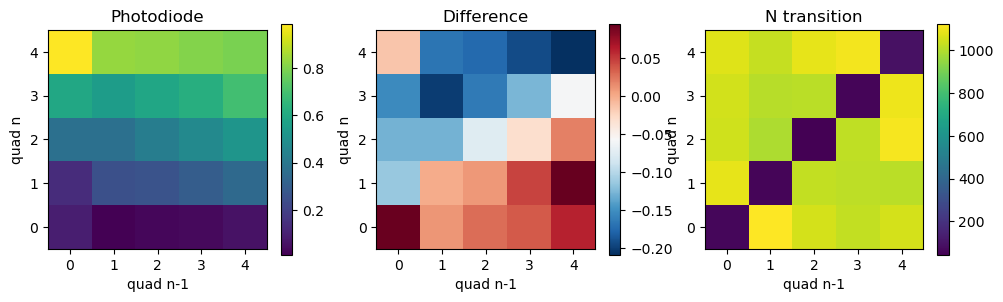

In [ ]:
mat_data = df.groupby(['quadcolor_before', 'quadcolor']).aggregate(np.nanmean).photodiode
n_data = df.groupby(['quadcolor_before', 'quadcolor']).aggregate(len).photodiode
m = mat_data.values.reshape((5, 5))
n = n_data.values.reshape((5, 5))
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.imshow(m.T, origin='lower')
cm = plt.colorbar()
plt.xlabel('quad n-1')
plt.ylabel('quad n')
plt.title('Photodiode')
plt.subplot(1,3,2)
plt.title('Difference')
plt.imshow((m-np.linspace(0,1,5)).T, origin='lower', cmap='RdBu_r')
plt.xlabel('quad n-1')
plt.ylabel('quad n')
cm = plt.colorbar()
plt.subplot(1,3,3)
plt.title('N transitions')
plt.imshow(n.T, origin='lower')
plt.xlabel('quad n-1')
plt.ylabel('quad n')
cm = plt.colorbar()


In [ ]:
fseries = frames_df.loc[4713]
fseries

onset_sample                      36034
offset_sample                     36041
peak_sample                       36038
include_skip                      False
onset_time              38454642.698016
offset_time             38454642.705024
peak_time               38454642.702016
lag_bef                           0.012
peak_corr_bef                  0.473087
closest_frame_bef                  4980
quadcolor_bef                      0.75
lag_center                        0.009
peak_corr_center               0.577479
closest_frame_center               4980
quadcolor_center                   0.75
lag_aft                           0.016
peak_corr_aft                  0.885755
closest_frame_aft                  4979
quadcolor_aft                       1.0
photodiode                     0.689815
is_jump                               0
closest_frame                    4979.0
lag                               0.016
sync_reason                    only fit
crosscorr_picked                    aft


In [ ]:
t0 = fseries.offset_time
frame_log['HarpTime'][1940:1955] - fseries.lag_aft - t0

1940   -21.751008
1941   -21.744000
1942   -21.736992
1943   -21.730016
1944   -21.723008
1945   -21.716000
1946   -21.708000
1947   -21.700992
1948   -21.694016
1949   -21.687008
1950   -21.680000
1951   -21.672992
1952   -21.666016
1953   -21.658016
1954   -21.651008
Name: HarpTime, dtype: float64

In [ ]:
frames_df.sync_reason.value_counts()

consensus                                   16098
only fit                                     2137
partial consensus                            1768
relative peak corr                           1114
not synced                                    722
relative peak corr & photodiode matching      264
photodiode matching                           159
fixing time travel (to past)                  115
fixing time travel (to future)                 91
Name: sync_reason, dtype: int64

# Divers stuff

Figures to explain things for my lab meeting (09/11/2022)

## Sequence principle

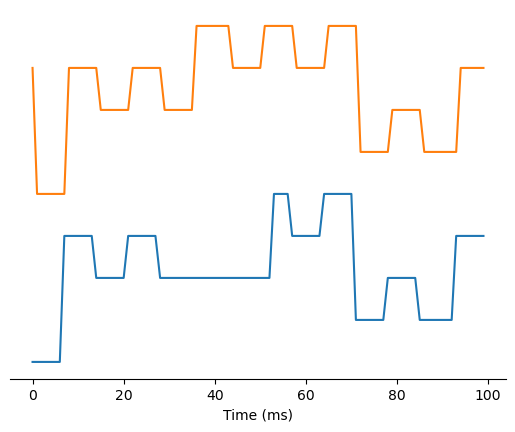

In [54]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
b = 1000
w = 100
shift = 1
0
seq = seq_trace[b:b+w]
bad_seq = np.array(seq_trace[b+shift: b+w+shift])
bad_seq[int(w/3):int(w/3 + w/3 * 0.6)] = bad_seq[int(w/3)]
ax.plot((ao_time[b:b+w] - ao_time[b])*1e3, bad_seq)
ax.plot((ao_time[b:b+w] - ao_time[b])*1e3, seq + 1)
ax.set_xlabel('Time (ms)')
ax.yaxis.set_visible(False)
for w in ['top', 'left', 'right']:
    ax.spines[w].set_visible(False)